In [35]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] =  '-1'
import networkx as nx
import tensorflow as tf
from tensorflow.keras import layers
import hoomd
import hoomd.md
import hoomd.htf as htf
import numpy as np
import gsd
import gsd.hoomd
import pickle
import matplotlib.pyplot as plt

In [36]:
# building a HTF model for coarse graining
# here use the single-molecule file for simplicity
# TODO: update to get one molecule from a .gsd with multiple
#       e.g. grab first entry in htf.find_molecules(system) -> do the rest
fname = '1-length-4-peek-para-only.gsd'
gsdfile = gsd.hoomd.open(fname)
context = hoomd.context.initialize('--mode=cpu')
system = hoomd.init.read_gsd(filename=fname)
context.sorter.disable()

notice(2): Group "all" created containing 88 particles


In [37]:
molecule_mapping_index = htf.find_molecules(system)

Finding molecules...0.00%


[(1, 0), (1, 87), (2, 1), (3, 2), (4, 86), (4, 3), (4, 5), (5, 6), (6, 7), (6, 85), (7, 8), (8, 9), (9, 10), (9, 84), (10, 12), (10, 11), (12, 83), (12, 13), (13, 14), (14, 81), (14, 15), (15, 16), (16, 17), (16, 80), (17, 18), (18, 19), (19, 79), (19, 20), (20, 21), (21, 78), (21, 22), (22, 23), (23, 24), (24, 77), (24, 25), (25, 26), (25, 27), (27, 28), (27, 76), (28, 29), (29, 30), (29, 74), (30, 31), (31, 32), (31, 73), (32, 33), (33, 34), (34, 72), (34, 35), (35, 36), (36, 71), (36, 37), (37, 38), (38, 39), (39, 40), (39, 70), (40, 41), (40, 42), (42, 69), (42, 43), (43, 44), (44, 67), (44, 45), (45, 46), (46, 47), (46, 66), (47, 48), (48, 49), (49, 50), (49, 65), (50, 51), (51, 52), (51, 64), (52, 53), (53, 54), (54, 63), (54, 55), (55, 57), (55, 56), (57, 62), (57, 58), (58, 59), (59, 60), (60, 61), (61, 62), (63, 64), (65, 66), (67, 68), (68, 69), (70, 71), (72, 73), (74, 75), (75, 76), (77, 78), (79, 80), (81, 82), (82, 83), (84, 85), (86, 87)]
[{0, 1, 2, 3, 4, 86, 87}, {5, 6,

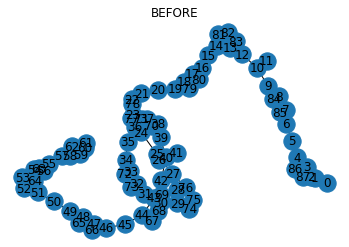

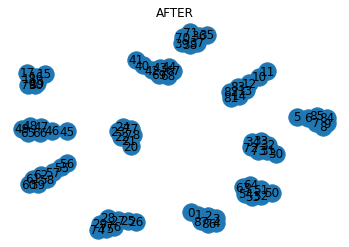

In [38]:
graph = nx.Graph()
# add all our particles and bonds
for particle in system.particles:
    graph.add_node(particle.tag, name=particle.type)
for bond in system.bonds:
    graph.add_edge(bond.a, bond.b)
plt.figure()
plt.title('BEFORE')
nx.draw(graph, with_labels=True)
# judiciously snip bonds
degrees_dict = dict(graph.degree())

print([(item.a, item.b) for item in list(system.bonds)])

for i, bond in enumerate(system.bonds):
    if bond.type == 'c-ca' or bond.type == 'ca-c':
        if degrees_dict[bond.a] == 3 and degrees_dict[bond.b] == 3:
            graph.remove_edge(bond.a, bond.b)
    elif bond.type == 'ca-os' or bond.type == 'os-ca':
        if degrees_dict[bond.a] == 2 and degrees_dict[bond.b] == 3 or\
        degrees_dict[bond.a] == 3 and degrees_dict[bond.b] == 2:
            graph.remove_edge(bond.a, bond.b)
    degrees_dict = dict(graph.degree())

subgraph_list = list(nx.connected_components(graph))
print(subgraph_list, len(subgraph_list))
print(type(subgraph_list[0]))
plt.figure()
plt.title('AFTER')
nx.draw(graph, with_labels=True)

In [39]:
# now we have our beads grouped up, we need to get their mapping
# get total N atoms
N = sum([len(m) for m in molecule_mapping_index])
# get molecule count
M = len(molecule_mapping_index)
# atoms per molecule
MN = len(molecule_mapping_index[0])
print('N_atoms:', N,'\nN_molecules:', M,'\nN_atoms_per_molecule:', MN)
# make sure we didn't miss any particles
assert(sum([len(item) for item in subgraph_list]) == MN)
print(len(subgraph_list))

N_atoms: 88 
N_molecules: 1 
N_atoms_per_molecule: 88
12


In [40]:
# create a mapping for our molecules
# these are 4-monomer polymers, and we're doing 3 beads per monomer
# therefore, we need a 12 x 88 matrix


mapping_arr = np.zeros((12,MN))

for i, subgraph in enumerate(subgraph_list):
    for atom_idx in subgraph:
        mapping_arr[i][atom_idx] = 1
        
N = sum([len(m) for m in molecule_mapping_index])
# get molecule count
M = len(molecule_mapping_index)
# atoms per molecule
MN = len(molecule_mapping_index[0])
print('N_atoms:', N,'\nN_molecules:', M,'\nN_atoms_per_molecule:', MN)
# again make sure we didn't miss any atoms
assert(np.sum(mapping_arr) == MN)

bead_number = mapping_arr.shape[0]



N_atoms: 88 
N_molecules: 1 
N_atoms_per_molecule: 88


In [41]:
fname = '100-length-4-peek-para-only-production.gsd'
gsdfile = gsd.hoomd.open(fname)
context = hoomd.context.initialize('--mode=cpu')
system = hoomd.init.read_gsd(filename=fname)
context.sorter.disable()
set_rcut = 11.0
molecule_mapping_index = htf.find_molecules(system)

cg_mapping = htf.sparse_mapping([mapping_arr for _ in molecule_mapping_index],
                               molecule_mapping_index, system=system)
N = sum([len(m) for m in molecule_mapping_index])
# get molecule count
M = len(molecule_mapping_index)
# atoms per molecule
MN = len(molecule_mapping_index[0])
print('N_atoms:', N,'\nN_molecules:', M,'\nN_atoms_per_molecule:', MN)
assert cg_mapping.shape == (M * bead_number, N)

notice(2): Group "all" created containing 8800 particles
Finding molecules...99.00%
N_atoms: 8800 
N_molecules: 100 
N_atoms_per_molecule: 88


In [42]:
import MDAnalysis as mda
univ = mda.Universe(fname)
print(univ.dimensions, fname)

[15.995788 15.995788 15.995788 90.       90.       90.      ] 100-length-4-peek-para-only-production.gsd


In [43]:
set(univ.atoms.types)

{'c', 'ca', 'o', 'oh', 'os'}

In [55]:
adjacency_matrix = np.eye(M*12)
for i in range(M*12):
    if i % 12 == 0:
        adjacency_matrix[i][i] = 0
class TrajModel(htf.SimModel):
    def setup(self, CG_NN, cg_mapping, rcut):
        self.CG_NN = CG_NN
        self.cg_mapping = cg_mapping
        self.rcut = rcut
    def compute(self, nlist, positions, box):
        # calculate the center of mass of a CG bead
        box_size = htf.box_size(box)
        mapped_pos = htf.center_of_mass(positions=positions[:,:3],
                                        mapping=self.cg_mapping, 
                                        box_size=[16.,16.,16.])
        print('made it past to mapped_pos')
        #cg_graph = htf.compute_cg_graph(DSGPM=False,
        #                               infile=None,
        #                               adj_mat=adjacency_matrix,
        #                               cg_beads=M*12)
        return mapped_pos, box, box_size
nneighbor_cutoff = 32
model = TrajModel(nneighbor_cutoff,
                 CG_NN = nneighbor_cutoff,
                 cg_mapping=cg_mapping,
                 output_forces=False,
                 rcut=set_rcut,
                 check_nlist=False)
print(adjacency_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [92]:
beads_per_molecule = 12
bonds_per_molecule = beads_per_molecule - 1 # linear polymer
bonds_matrix = np.zeros([bonds_per_molecule * M, 2])
#print(M)
bonds_matrix[0][1] = 1
offset = 0

for i in range(1, bonds_matrix.shape[0]):
    bonds_matrix[i][0] = i + i//11
    bonds_matrix[i][1] = i+1 + i//11
    
def make_frame(i, positions):
    s = gsd.hoomd.Snapshot()
    s.configuration.box = [16.,16.,16., 0., 0., 0.]
    s.configuration.step = i
    s.particles.N = beads_per_molecule * M
    s.particles.position = positions
    s.bonds.N = bonds_per_molecule * M
    s.bonds.group = bonds_matrix
    #print(s)
    return s

print(f'Applying CG mapping to {fname}')
f = gsd.hoomd.open(name=f'CG_traj-{fname}', mode='wb+')
i = 0
for inputs, ts in htf.iter_from_trajectory(nneighbor_cutoff, univ, r_cut=set_rcut):
    #print(i)
    i+=1
    result = model(inputs)
    #print(result[0], np.array(result[0].shape))
    particle_positions = np.array(result[0])
    f.append(make_frame(i, particle_positions))

100
[[ 0.  1.]
 [ 1.  2.]
 [ 2.  3.]
 [ 3.  4.]
 [ 4.  5.]
 [ 5.  6.]
 [ 6.  7.]
 [ 7.  8.]
 [ 8.  9.]
 [ 9. 10.]
 [10. 11.]
 [12. 13.]
 [13. 14.]
 [14. 15.]
 [15. 16.]
 [16. 17.]
 [17. 18.]
 [18. 19.]
 [19. 20.]
 [20. 21.]
 [21. 22.]
 [22. 23.]
 [24. 25.]
 [25. 26.]]
[[1086. 1087.]
 [1087. 1088.]
 [1088. 1089.]
 [1089. 1090.]
 [1090. 1091.]
 [1092. 1093.]
 [1093. 1094.]
 [1094. 1095.]
 [1095. 1096.]
 [1096. 1097.]
 [1097. 1098.]
 [1098. 1099.]
 [1099. 1100.]
 [1100. 1101.]
 [1101. 1102.]
 [1102. 1103.]
 [1104. 1105.]
 [1105. 1106.]
 [1106. 1107.]
 [1107. 1108.]
 [1108. 1109.]
 [1109. 1110.]
 [1110. 1111.]
 [1111. 1112.]
 [1112. 1113.]
 [1113. 1114.]
 [1114. 1115.]
 [1116. 1117.]
 [1117. 1118.]
 [1118. 1119.]
 [1119. 1120.]
 [1120. 1121.]
 [1121. 1122.]
 [1122. 1123.]
 [1123. 1124.]
 [1124. 1125.]
 [1125. 1126.]
 [1126. 1127.]
 [1128. 1129.]
 [1129. 1130.]
 [1130. 1131.]
 [1131. 1132.]
 [1132. 1133.]
 [1133. 1134.]
 [1134. 1135.]
 [1135. 1136.]
 [1136. 1137.]
 [1137. 1138.]
 [1138. 113

In [ ]:
start_idx = 0

ccrdf = model.avg_ccrdf.result().numpy()
plt.figure()
plt.plot(ccrdf[1, start_idx:], ccrdf[0, start_idx:], label='C-C', color='C1')
plt.title(r'C-C RDF')
plt.xlabel(r'r')
plt.ylabel(r'g(r)')
plt.legend()
plt.show()

cordf = model.avg_cordf.result().numpy()
plt.figure()
plt.plot(ccrdf[1, start_idx:], cordf[0, start_idx:], label='C-O', color='C1')
plt.title(r'C-O RDF')
plt.xlabel(r'r')
plt.ylabel(r'g(r)')
plt.legend()
plt.show()

cordf = model.avg_oordf.result().numpy()
plt.figure()
plt.plot(ccrdf[1, start_idx:], cordf[0, start_idx:], label='C-O', color='C1')
plt.title(r'C-O RDF')
plt.xlabel(r'r')
plt.ylabel(r'g(r)')
plt.legend()
plt.show()